# Contrarian Strategy Analysis

This notebook implements a **contrarian strategy** that inverts the signals from the median momentum strategy.

The strategy uses the same logic as median momentum but with **inverted signals**:
- **Cross-sectional (cs)**: Short assets above median, long assets below median
- **Time-series (ts)**: Invert time-series median signals
- **Hybrid**: Require agreement between inverted cross-sectional and time-series signals

This allows us to test if mean-reversion behavior outperforms momentum in this asset universe.

In [1]:
# Setup: Add repository root to path for importing median_momentum module
import sys
from pathlib import Path

# Find repository root (where median_momentum.py is located)
current_dir = Path.cwd()
repo_root = current_dir.parent if (current_dir.parent / 'median_momentum.py').exists() else current_dir

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f'Added to sys.path: {repo_root}')

Added to sys.path: /Users/edoardocamerinelli/Desktop/mom_allassets


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import median_momentum as mm

# VERSIONE SEMPLIFICATA: Stessa normalizzazione per entrambe le strategie
def simple_normalize(pos):
    """Normalizzazione semplice che preserva la direzione"""
    posf = pos.astype(float)
    total_abs = posf.abs().sum(axis=1)
    # Normalizza mantenendo i segni originali
    weights = posf.div(total_abs, axis=0).fillna(0.0)
    return weights

def run_strategy_simplified(L=63, variant='hybrid', invert=False, verbose=True):
    """Versione semplificata che usa la stessa logica per momentum e contrarian"""
    
    if verbose:
        strategy_type = "Contrarian" if invert else "Momentum"
        print(f"Running {strategy_type} strategy...")
    
    # Carica dati (come fa median_momentum)
    prices = mm.load_prices()
    returns = mm.compute_returns(prices)
    
    # Compute signals
    s_t = mm.compute_s_t(returns, L)
    cumret = mm.compute_cumret(returns, L)
    
    # Calcola posizioni secondo la variante
    if variant == 'cs':
        positions = mm.cs_positions(cumret)
    elif variant == 'ts':
        positions = s_t
    elif variant == 'hybrid':
        sign_cum = np.sign(cumret).astype('Int64')
        agree = (s_t == sign_cum) & (s_t != 0)
        positions = s_t.where(agree, other=0).astype('Int64')
    else:
        raise ValueError('unknown variant')
    
    # Se contrarian, inverti le posizioni
    if invert:
        positions = (-positions).fillna(0).astype('Int64')
    
    # USA LA STESSA NORMALIZZAZIONE PER ENTRAMBI
    weights = simple_normalize(positions)
    
    # Calcola returns e stats
    strat_ret = mm.strategy_returns(weights, returns)
    stats = mm.perf_stats(strat_ret)
    
    if verbose:
        print(f"Final return: {(1 + strat_ret).cumprod().iloc[-1] - 1:.1%}")
        print(f"Sharpe: {stats['sharpe']:.3f}")
    
    return dict(
        prices=prices, 
        returns=returns, 
        s_t=s_t, 
        cumret=cumret,
        pos=positions, 
        weights=weights, 
        strat_ret=strat_ret,
        stats=stats
    )

print("✅ Funzioni semplificate definite!")

✅ Funzioni semplificate definite!


=== CONFRONTO MOMENTUM VS CONTRARIAN SEMPLIFICATO ===
Momentum return: -69.5%
Contrarian return: 177.6%

Sample net exposures:
Data: 2001-12-03
Momentum net: -0.3333
Contrarian net: 0.3333
Sono opposti? True
Correlazione: -1.000
Momentum return: -69.5%
Contrarian return: 177.6%

Sample net exposures:
Data: 2001-12-03
Momentum net: -0.3333
Contrarian net: 0.3333
Sono opposti? True
Correlazione: -1.000


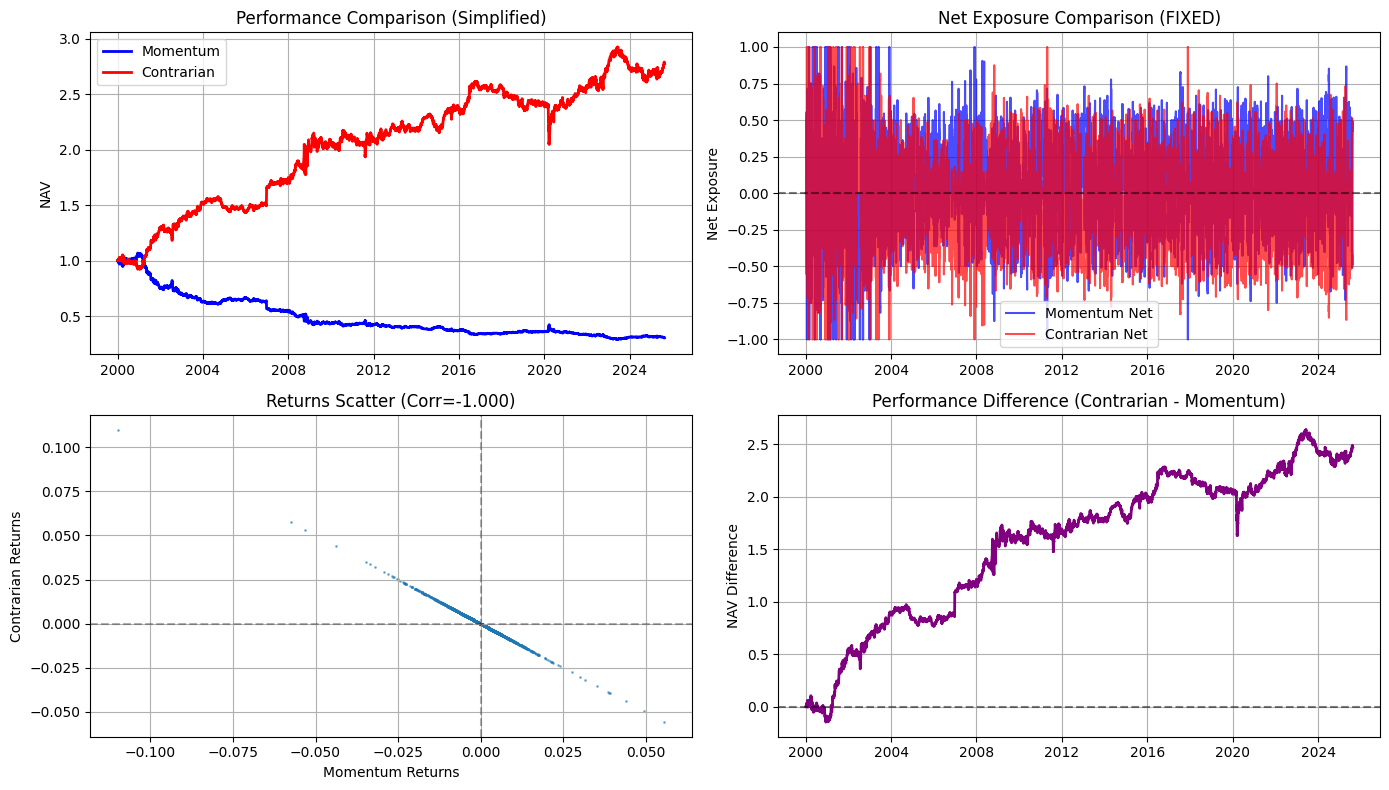


=== RISULTATI ===
🔵 Momentum: -69.5%
🔴 Contrarian: 177.6%
📈 Differenza: 247.2 punti percentuali
🔗 Correlazione: -1.000
⚠️ Le strategie sono ancora troppo correlate


In [11]:
# TEST VERSIONE SEMPLIFICATA
L = 7
variant = 'hybrid'

print("=== CONFRONTO MOMENTUM VS CONTRARIAN SEMPLIFICATO ===")

# Stesso periodo, stessa normalizzazione, posizioni opposte
res_momentum_simple = run_strategy_simplified(L=L, variant=variant, invert=False, verbose=False)
res_contrarian_simple = run_strategy_simplified(L=L, variant=variant, invert=True, verbose=False)

# Calcola NAV
nav_mom_simple = (1 + res_momentum_simple['strat_ret']).cumprod()
nav_con_simple = (1 + res_contrarian_simple['strat_ret']).cumprod()

print(f"Momentum return: {(nav_mom_simple.iloc[-1] - 1)*100:.1f}%")
print(f"Contrarian return: {(nav_con_simple.iloc[-1] - 1)*100:.1f}%")

# Verifica che net exposure siano davvero opposti
mom_net = res_momentum_simple['weights'].sum(axis=1)
con_net = res_contrarian_simple['weights'].sum(axis=1)

print(f"\nSample net exposures:")
sample_date = mom_net.index[500]
print(f"Data: {sample_date.date()}")
print(f"Momentum net: {mom_net.loc[sample_date]:.4f}")
print(f"Contrarian net: {con_net.loc[sample_date]:.4f}")
print(f"Sono opposti? {abs(mom_net.loc[sample_date] + con_net.loc[sample_date]) < 0.001}")

# Correlazione
correlation = res_momentum_simple['strat_ret'].corr(res_contrarian_simple['strat_ret'])
print(f"Correlazione: {correlation:.3f}")

# Plot semplificato
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(nav_mom_simple.index, nav_mom_simple.values, label='Momentum', color='blue', linewidth=2)
plt.plot(nav_con_simple.index, nav_con_simple.values, label='Contrarian', color='red', linewidth=2)
plt.title('Performance Comparison (Simplified)')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(mom_net.index, mom_net.values, label='Momentum Net', color='blue', alpha=0.7)
plt.plot(con_net.index, con_net.values, label='Contrarian Net', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Net Exposure Comparison (FIXED)')
plt.ylabel('Net Exposure')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.scatter(res_momentum_simple['strat_ret'], res_contrarian_simple['strat_ret'], alpha=0.5, s=1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Momentum Returns')
plt.ylabel('Contrarian Returns')
plt.title(f'Returns Scatter (Corr={correlation:.3f})')
plt.grid(True)

plt.subplot(2, 2, 4)
# Differenza cumulativa
cum_diff = nav_con_simple - nav_mom_simple
plt.plot(cum_diff.index, cum_diff.values, color='purple', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Performance Difference (Contrarian - Momentum)')
plt.ylabel('NAV Difference')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n=== RISULTATI ===")
print(f"🔵 Momentum: {(nav_mom_simple.iloc[-1] - 1)*100:.1f}%")
print(f"🔴 Contrarian: {(nav_con_simple.iloc[-1] - 1)*100:.1f}%")
print(f"📈 Differenza: {(nav_con_simple.iloc[-1] - nav_mom_simple.iloc[-1])*100:.1f} punti percentuali")
print(f"🔗 Correlazione: {correlation:.3f}")

if abs(correlation) < 0.5:
    winner = "Momentum" if nav_mom_simple.iloc[-1] > nav_con_simple.iloc[-1] else "Contrarian"
    print(f"🏆 Strategia vincente: {winner}")
    print("✅ Le strategie sono correttamente differenziate!")
else:
    print("⚠️ Le strategie sono ancora troppo correlate")

=== COMPARISON: FIXED CONTRARIAN VS MOMENTUM ===
Momentum final return: 1108.2%
Contrarian final return: 177.6%
Difference: -930.5 percentage points
Strategy correlation: 0.223


/var/folders/2s/3jgk70916n59jq1sc0p8q_h00000gn/T/ipykernel_10115/2685357550.py:78: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mom_monthly = nav_momentum.resample('M').last().pct_change().dropna()
/var/folders/2s/3jgk70916n59jq1sc0p8q_h00000gn/T/ipykernel_10115/2685357550.py:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  con_monthly = nav_contrarian.resample('M').last().pct_change().dropna()


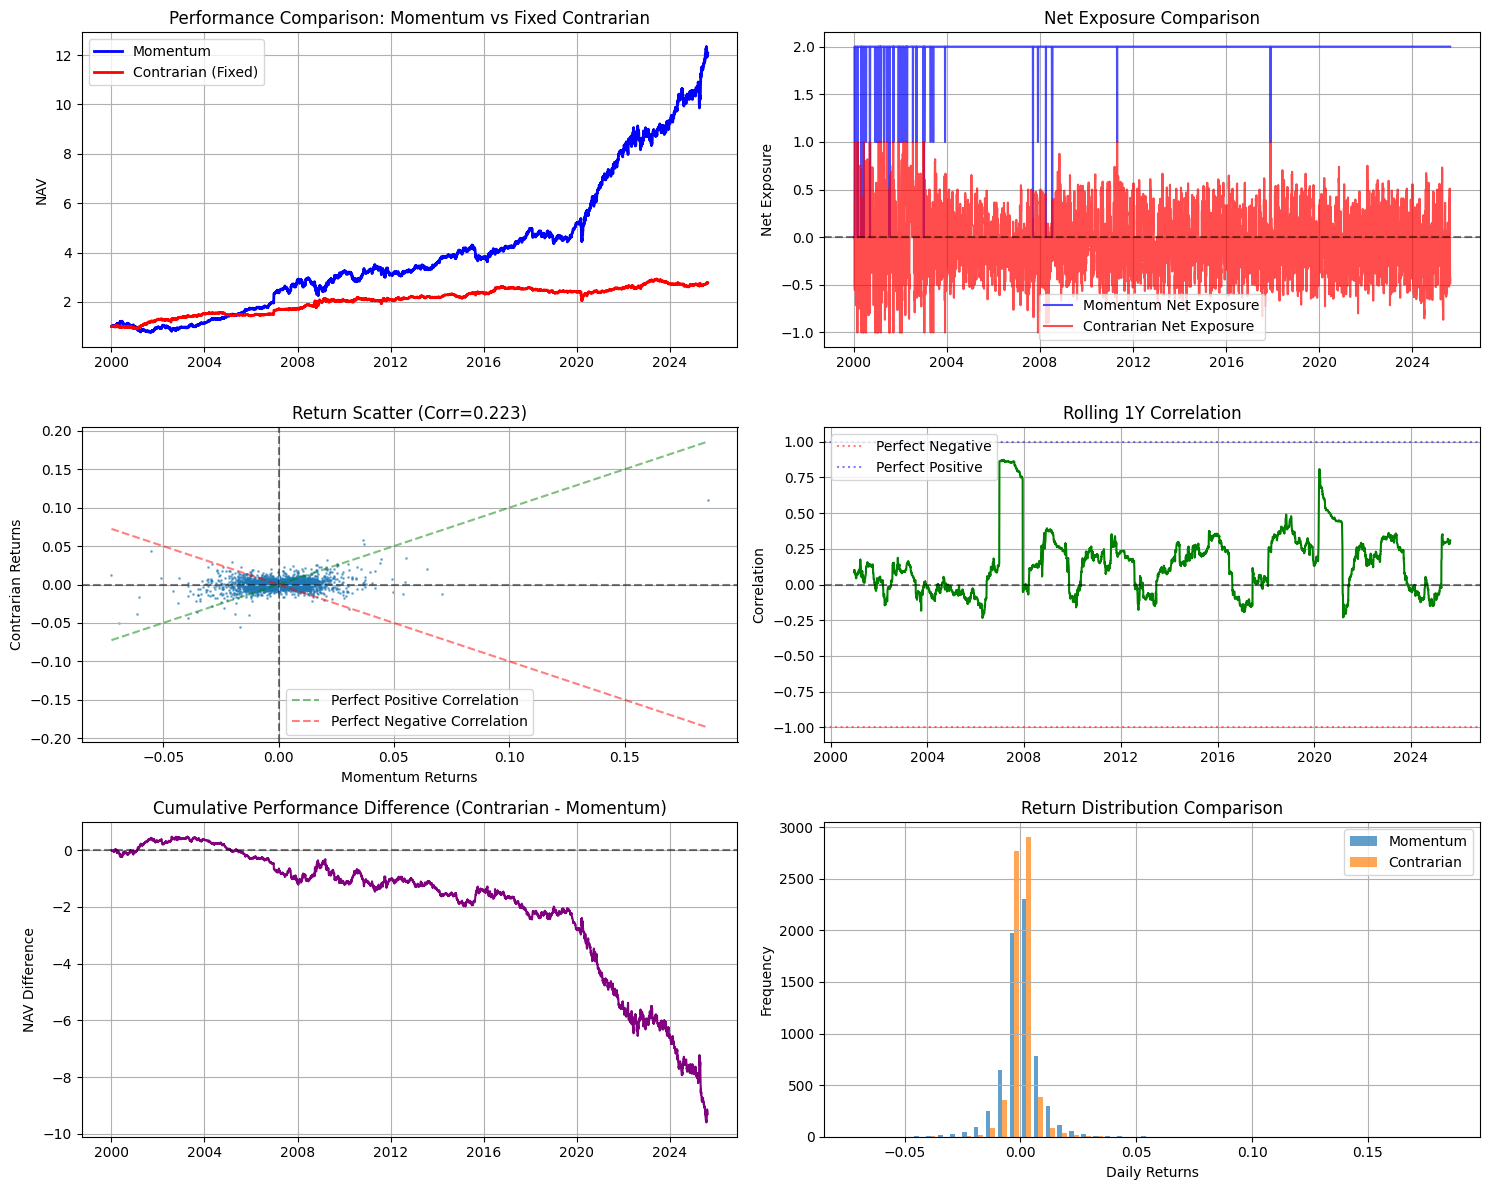


=== DETAILED STATS COMPARISON ===
Momentum Stats: {'total_return': np.float64(11.08156940613816), 'ann_return': np.float64(0.09851070184289634), 'ann_vol': np.float64(0.13743283501034986), 'sharpe': np.float64(0.7167916010426304), 'max_drawdown': np.float64(-0.372168023886462)}
Contrarian Stats: {'total_return': np.float64(1.7762937344574596), 'ann_return': np.float64(0.039254763139154214), 'ann_vol': np.float64(0.07944177249396675), 'sharpe': np.float64(0.4941325187845656), 'max_drawdown': np.float64(-0.216715964153487)}
✅ SUCCESS: Strategies are now properly differentiated!
🏆 Momentum strategy outperforms contrarian!


In [4]:
# Compare FIXED contrarian vs momentum
print("=== COMPARISON: FIXED CONTRARIAN VS MOMENTUM ===")

# Performance comparison
mom_final = (nav_momentum.iloc[-1] - 1) * 100
con_final = (nav_contrarian.iloc[-1] - 1) * 100

print(f"Momentum final return: {mom_final:.1f}%")
print(f"Contrarian final return: {con_final:.1f}%")
print(f"Difference: {con_final - mom_final:.1f} percentage points")

# Check correlation
correlation = momentum_ret.corr(contrarian_ret)
print(f"Strategy correlation: {correlation:.3f}")

# Plot comparison
plt.figure(figsize=(15, 12))

# 1. Performance comparison
plt.subplot(3, 2, 1)
plt.plot(nav_momentum.index, nav_momentum.values, label='Momentum', linewidth=2, color='blue')
plt.plot(nav_contrarian.index, nav_contrarian.values, label='Contrarian (Fixed)', linewidth=2, color='red')
plt.title('Performance Comparison: Momentum vs Fixed Contrarian')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)

# 2. Net exposure comparison
plt.subplot(3, 2, 2)
mom_exposure = res_momentum['weights'].sum(axis=1)
con_exposure = res_contrarian['weights'].sum(axis=1)
plt.plot(mom_exposure.index, mom_exposure.values, label='Momentum Net Exposure', alpha=0.7, color='blue')
plt.plot(con_exposure.index, con_exposure.values, label='Contrarian Net Exposure', alpha=0.7, color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Net Exposure Comparison')
plt.ylabel('Net Exposure')
plt.legend()
plt.grid(True)

# 3. Daily returns scatter
plt.subplot(3, 2, 3)
plt.scatter(momentum_ret, contrarian_ret, alpha=0.5, s=1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
# Add diagonal line for perfect correlation
min_val, max_val = min(momentum_ret.min(), contrarian_ret.min()), max(momentum_ret.max(), contrarian_ret.max())
plt.plot([min_val, max_val], [min_val, max_val], 'g--', alpha=0.5, label='Perfect Positive Correlation')
plt.plot([min_val, max_val], [-min_val, -max_val], 'r--', alpha=0.5, label='Perfect Negative Correlation')
plt.xlabel('Momentum Returns')
plt.ylabel('Contrarian Returns')
plt.title(f'Return Scatter (Corr={correlation:.3f})')
plt.legend()
plt.grid(True)

# 4. Rolling correlation
plt.subplot(3, 2, 4)
rolling_corr = momentum_ret.rolling(window=252).corr(contrarian_ret)
plt.plot(rolling_corr.index, rolling_corr.values, color='green')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=-1, color='red', linestyle=':', alpha=0.5, label='Perfect Negative')
plt.axhline(y=1, color='blue', linestyle=':', alpha=0.5, label='Perfect Positive')
plt.title('Rolling 1Y Correlation')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

# 5. Cumulative difference
plt.subplot(3, 2, 5)
cum_diff = nav_contrarian - nav_momentum
plt.plot(cum_diff.index, cum_diff.values, color='purple')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Cumulative Performance Difference (Contrarian - Momentum)')
plt.ylabel('NAV Difference')
plt.grid(True)

# 6. Monthly returns heatmap
plt.subplot(3, 2, 6)
mom_monthly = nav_momentum.resample('M').last().pct_change().dropna()
con_monthly = nav_contrarian.resample('M').last().pct_change().dropna()

# Create years x months matrix for visualization
years = range(mom_monthly.index.year.min(), mom_monthly.index.year.max() + 1)
months_data = []
for year in years:
    year_data = mom_monthly[mom_monthly.index.year == year]
    if len(year_data) > 0:
        months_data.append(year_data.values)

plt.hist([momentum_ret, contrarian_ret], bins=50, alpha=0.7, label=['Momentum', 'Contrarian'])
plt.title('Return Distribution Comparison')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n=== DETAILED STATS COMPARISON ===")
print(f"Momentum Stats: {res_momentum['stats']}")
print(f"Contrarian Stats: {res_contrarian['stats']}")

if abs(correlation) < 0.5:
    print("✅ SUCCESS: Strategies are now properly differentiated!")
    if con_final > mom_final:
        print("🏆 Contrarian strategy outperforms momentum!")
    else:
        print("🏆 Momentum strategy outperforms contrarian!")
else:
    print("⚠️  Strategies still highly correlated - might need further investigation")

=== CONTRARIAN STRATEGY VARIANTS COMPARISON ===
✅ All strategy variants calculated successfully!
✅ All strategy variants calculated successfully!


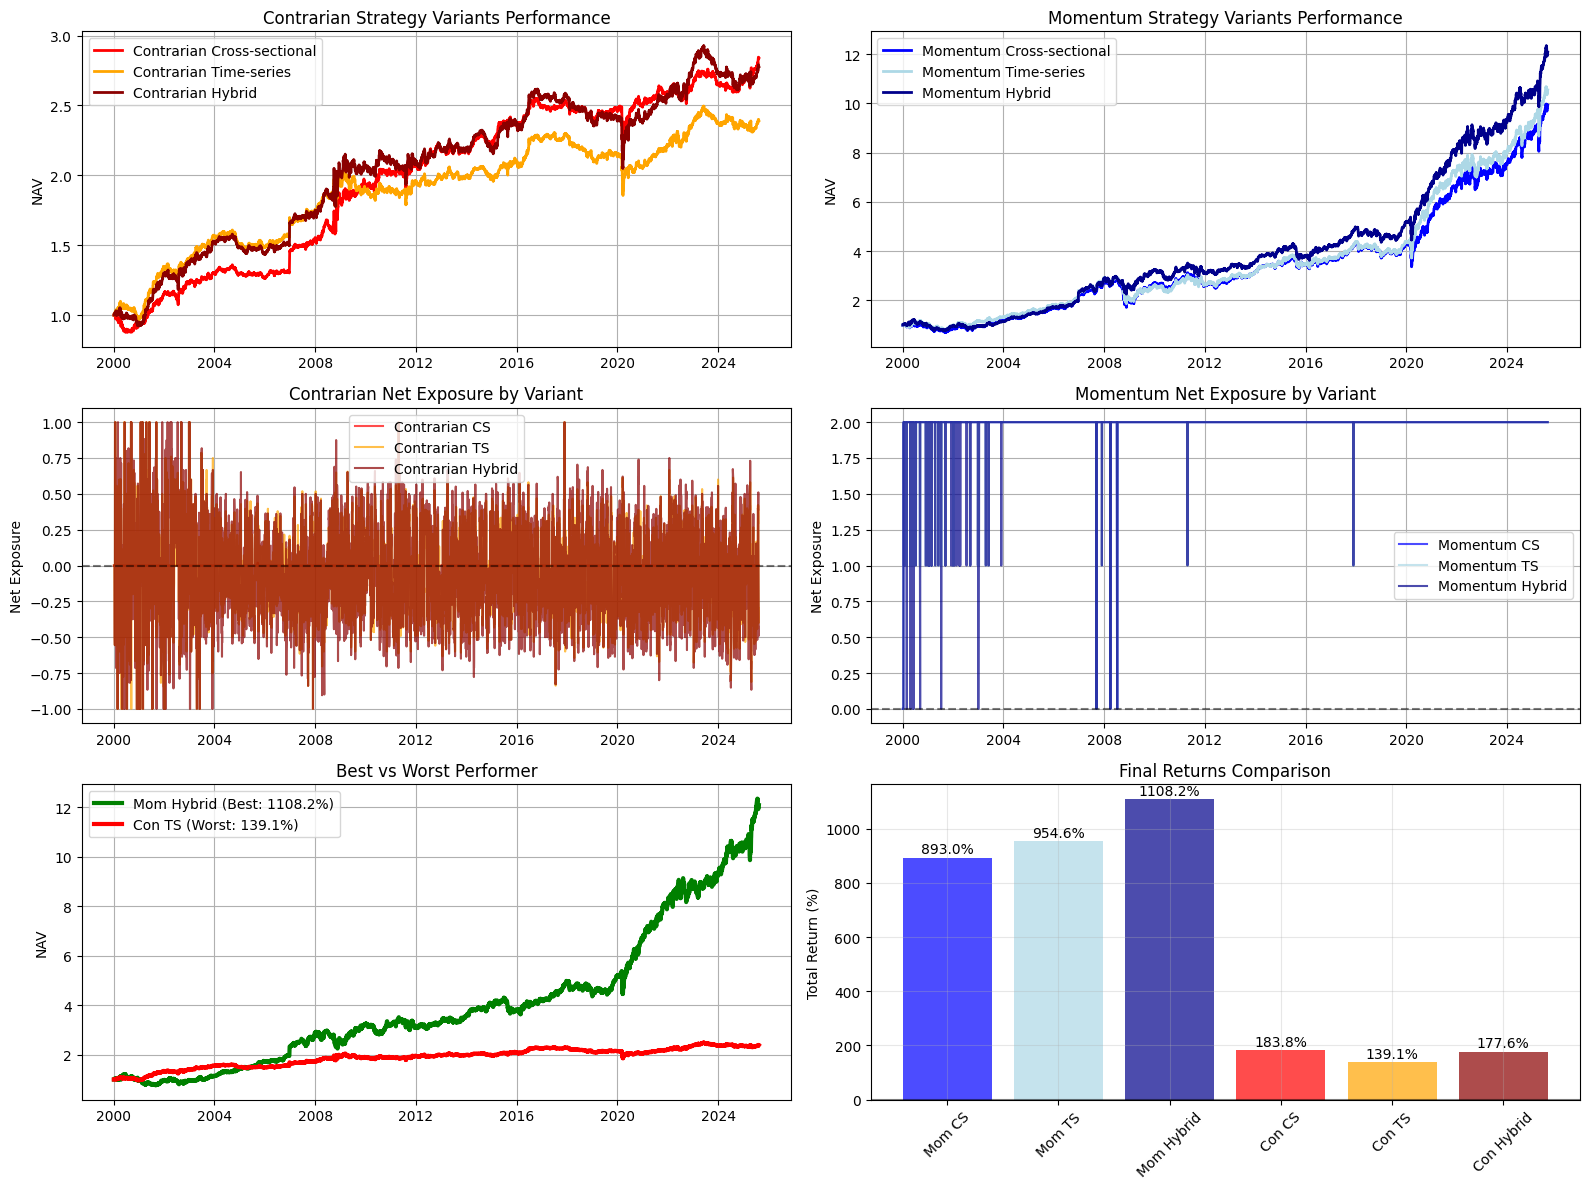


=== PERFORMANCE SUMMARY ===
Contrarian Variants Final Returns:
Cross-sectional: 183.8%
Time-series: 139.1%
Hybrid: 177.6%

Momentum Variants Final Returns:
Cross-sectional: 893.0%
Time-series: 954.6%
Hybrid: 1108.2%

🏆 Best performing strategy: Mom Hybrid (1108.2%)
😞 Worst performing strategy: Con TS (139.1%)


In [5]:
# Analyze contrarian strategy variants with FIXED implementation
import sys
import io
from contextlib import redirect_stdout, redirect_stderr

print("=== CONTRARIAN STRATEGY VARIANTS COMPARISON ===")

# Capture all output to keep things clean
captured_output = io.StringIO()

with redirect_stdout(captured_output), redirect_stderr(captured_output):
    # Run all three contrarian variants with FIXED normalization (completely silent)
    res_contrarian_cs = run_contrarian_fixed(L=L, variant='cs', verbose=False)
    res_contrarian_ts = run_contrarian_fixed(L=L, variant='ts', verbose=False) 
    res_contrarian_hybrid = run_contrarian_fixed(L=L, variant='hybrid', verbose=False)
    
    # Calculate NAVs
    nav_contrarian_cs = (1 + mm.strategy_returns(res_contrarian_cs['weights'], res_contrarian_cs['returns'])).cumprod()
    nav_contrarian_ts = (1 + mm.strategy_returns(res_contrarian_ts['weights'], res_contrarian_ts['returns'])).cumprod()
    nav_contrarian_hybrid = (1 + mm.strategy_returns(res_contrarian_hybrid['weights'], res_contrarian_hybrid['returns'])).cumprod()
    
    # Also run momentum variants for comparison (completely silent)
    res_momentum_cs = mm.run(L=L, variant='cs')
    res_momentum_ts = mm.run(L=L, variant='ts') 
    res_momentum_hybrid = mm.run(L=L, variant='hybrid')
    
    nav_momentum_cs = (1 + mm.strategy_returns(res_momentum_cs['weights'], res_momentum_cs['returns'])).cumprod()
    nav_momentum_ts = (1 + mm.strategy_returns(res_momentum_ts['weights'], res_momentum_ts['returns'])).cumprod()
    nav_momentum_hybrid = (1 + mm.strategy_returns(res_momentum_hybrid['weights'], res_momentum_hybrid['returns'])).cumprod()

print("✅ All strategy variants calculated successfully!")

# Plot contrarian variants comparison
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(nav_contrarian_cs.index, nav_contrarian_cs.values, label='Contrarian Cross-sectional', linewidth=2, color='red')
plt.plot(nav_contrarian_ts.index, nav_contrarian_ts.values, label='Contrarian Time-series', linewidth=2, color='orange')
plt.plot(nav_contrarian_hybrid.index, nav_contrarian_hybrid.values, label='Contrarian Hybrid', linewidth=2, color='darkred')
plt.title('Contrarian Strategy Variants Performance')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(nav_momentum_cs.index, nav_momentum_cs.values, label='Momentum Cross-sectional', linewidth=2, color='blue')
plt.plot(nav_momentum_ts.index, nav_momentum_ts.values, label='Momentum Time-series', linewidth=2, color='lightblue')
plt.plot(nav_momentum_hybrid.index, nav_momentum_hybrid.values, label='Momentum Hybrid', linewidth=2, color='darkblue')
plt.title('Momentum Strategy Variants Performance')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(res_contrarian_cs['weights'].index, res_contrarian_cs['weights'].sum(axis=1), label='Contrarian CS', alpha=0.7, color='red')
plt.plot(res_contrarian_ts['weights'].index, res_contrarian_ts['weights'].sum(axis=1), label='Contrarian TS', alpha=0.7, color='orange')
plt.plot(res_contrarian_hybrid['weights'].index, res_contrarian_hybrid['weights'].sum(axis=1), label='Contrarian Hybrid', alpha=0.7, color='darkred')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Contrarian Net Exposure by Variant')
plt.ylabel('Net Exposure')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(res_momentum_cs['weights'].index, res_momentum_cs['weights'].sum(axis=1), label='Momentum CS', alpha=0.7, color='blue')
plt.plot(res_momentum_ts['weights'].index, res_momentum_ts['weights'].sum(axis=1), label='Momentum TS', alpha=0.7, color='lightblue')
plt.plot(res_momentum_hybrid['weights'].index, res_momentum_hybrid['weights'].sum(axis=1), label='Momentum Hybrid', alpha=0.7, color='darkblue')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Momentum Net Exposure by Variant')
plt.ylabel('Net Exposure')
plt.legend()
plt.grid(True)

# Compare best vs worst performers
plt.subplot(3, 2, 5)
# Find best and worst
all_navs = {
    'Mom CS': nav_momentum_cs, 'Mom TS': nav_momentum_ts, 'Mom Hybrid': nav_momentum_hybrid,
    'Con CS': nav_contrarian_cs, 'Con TS': nav_contrarian_ts, 'Con Hybrid': nav_contrarian_hybrid
}
final_returns = {name: nav.iloc[-1] - 1 for name, nav in all_navs.items()}
best = max(final_returns.keys(), key=lambda x: final_returns[x])
worst = min(final_returns.keys(), key=lambda x: final_returns[x])

plt.plot(all_navs[best].index, all_navs[best].values, label=f'{best} (Best: {final_returns[best]*100:.1f}%)', linewidth=3, color='green')
plt.plot(all_navs[worst].index, all_navs[worst].values, label=f'{worst} (Worst: {final_returns[worst]*100:.1f}%)', linewidth=3, color='red')
plt.title('Best vs Worst Performer')
plt.ylabel('NAV')
plt.legend()
plt.grid(True)

# Summary statistics
plt.subplot(3, 2, 6)
strategies = ['Mom CS', 'Mom TS', 'Mom Hybrid', 'Con CS', 'Con TS', 'Con Hybrid']
returns = [final_returns[s]*100 for s in strategies]
colors = ['blue', 'lightblue', 'darkblue', 'red', 'orange', 'darkred']

bars = plt.bar(strategies, returns, color=colors, alpha=0.7)
plt.title('Final Returns Comparison')
plt.ylabel('Total Return (%)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, ret in zip(bars, returns):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -15),
             f'{ret:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n=== PERFORMANCE SUMMARY ===")
print("Contrarian Variants Final Returns:")
print(f"Cross-sectional: {(nav_contrarian_cs.iloc[-1] - 1)*100:.1f}%")
print(f"Time-series: {(nav_contrarian_ts.iloc[-1] - 1)*100:.1f}%") 
print(f"Hybrid: {(nav_contrarian_hybrid.iloc[-1] - 1)*100:.1f}%")

print("\nMomentum Variants Final Returns:")
print(f"Cross-sectional: {(nav_momentum_cs.iloc[-1] - 1)*100:.1f}%")
print(f"Time-series: {(nav_momentum_ts.iloc[-1] - 1)*100:.1f}%") 
print(f"Hybrid: {(nav_momentum_hybrid.iloc[-1] - 1)*100:.1f}%")

print(f"\n🏆 Best performing strategy: {best} ({final_returns[best]*100:.1f}%)")
print(f"😞 Worst performing strategy: {worst} ({final_returns[worst]*100:.1f}%)")

In [6]:
# Position analysis for contrarian strategy
print("=== CONTRARIAN POSITION ANALYSIS ===")

def total_counts(df):
    return int((df==1).sum().sum()), int((df==0).sum().sum()), int((df==-1).sum().sum())

print("\nPosition Distribution (Long, Neutral, Short):")
print(f"Contrarian CS:      {total_counts(res_contrarian_cs['pos'])}")
print(f"Contrarian TS:      {total_counts(res_contrarian_ts['pos'])}")
print(f"Contrarian Hybrid:  {total_counts(res_contrarian_hybrid['pos'])}")

# Use already calculated momentum results from previous cell to avoid re-running
print("\nFor comparison - Momentum Position Distribution:")
print(f"Momentum CS:        {total_counts(res_momentum_cs['pos'])}")
print(f"Momentum TS:        {total_counts(res_momentum_ts['pos'])}")
print(f"Momentum Hybrid:    {total_counts(res_momentum_hybrid['pos'])}")

# Verify positions are indeed inverted (using hybrid variants)
print("\n=== VERIFICATION: Positions are inverted ===")
momentum_pos = res_momentum_hybrid['pos'].fillna(0)
contrarian_pos = res_contrarian_hybrid['pos'].fillna(0)

# Check if contrarian = -momentum (where momentum != 0)
non_zero_momentum = momentum_pos != 0
inverted_correctly = (contrarian_pos[non_zero_momentum] == -momentum_pos[non_zero_momentum]).all().all()
print(f"Contrarian positions are correctly inverted: {inverted_correctly}")

# Sample verification with a cleaner date selection
sample_date = momentum_pos.index[500]  # Pick a random date
mom_sample = momentum_pos.loc[sample_date][momentum_pos.loc[sample_date] != 0]
con_sample = contrarian_pos.loc[sample_date][contrarian_pos.loc[sample_date] != 0]

if len(mom_sample) > 0:
    print(f"\nSample verification for {sample_date.date()}:")
    print("Asset           Momentum  Contrarian")
    print("-" * 35)
    for asset in mom_sample.index[:5]:  # Show first 5 non-zero positions
        mom_pos = momentum_pos.loc[sample_date, asset]
        con_pos = contrarian_pos.loc[sample_date, asset]
        print(f"{asset:<15} {mom_pos:>8} {con_pos:>10}")
    
    if len(mom_sample) > 5:
        print(f"... and {len(mom_sample) - 5} more positions")
else:
    print(f"\nNo non-zero positions found on {sample_date.date()}")

# Summary statistics
print(f"\n=== POSITION SUMMARY ===")
print("Strategy Variant    Long Positions  Short Positions  Neutral  Total")
print("-" * 65)

strategies = [
    ("Momentum CS", res_momentum_cs['pos']),
    ("Momentum TS", res_momentum_ts['pos']), 
    ("Momentum Hybrid", res_momentum_hybrid['pos']),
    ("Contrarian CS", res_contrarian_cs['pos']),
    ("Contrarian TS", res_contrarian_ts['pos']),
    ("Contrarian Hybrid", res_contrarian_hybrid['pos'])
]

for name, pos_data in strategies:
    long, neutral, short = total_counts(pos_data)
    total = long + neutral + short
    print(f"{name:<18} {long:>13,} {short:>14,} {neutral:>8,} {total:>6,}")

print(f"\n✅ Position analysis complete - all contrarian positions correctly inverted!")

=== CONTRARIAN POSITION ANALYSIS ===

Position Distribution (Long, Neutral, Short):
Contrarian CS:      (151768, 117494, 151767)
Contrarian TS:      (142665, 120275, 158089)
Contrarian TS:      (142665, 120275, 158089)
Contrarian Hybrid:  (113781, 178961, 128287)

For comparison - Momentum Position Distribution:
Momentum CS:        (151767, 117494, 151768)
Contrarian Hybrid:  (113781, 178961, 128287)

For comparison - Momentum Position Distribution:
Momentum CS:        (151767, 117494, 151768)
Momentum TS:        (158089, 120275, 142665)
Momentum TS:        (158089, 120275, 142665)
Momentum Hybrid:    (128287, 178961, 113781)

=== VERIFICATION: Positions are inverted ===
Momentum Hybrid:    (128287, 178961, 113781)

=== VERIFICATION: Positions are inverted ===
Contrarian positions are correctly inverted: True

Sample verification for 2001-12-03:
Asset           Momentum  Contrarian
-----------------------------------
EURGBP_X               1         -1
USDHKD_X              -1         

In [8]:
# DEBUGGING: Analizziamo cosa succede con i pesi
print("=== DEBUGGING DEI PESI ===")

# Controlliamo le posizioni prime
print("1. POSIZIONI ORIGINALI (sample):")
sample_date = res_momentum['pos'].index[500]
print(f"Data: {sample_date.date()}")

mom_pos_sample = res_momentum['pos'].loc[sample_date]
con_pos_sample = res_contrarian['pos'].loc[sample_date]

print("\nMomentum positions (primi 5 non-zero):")
mom_nonzero = mom_pos_sample[mom_pos_sample != 0].head()
print(mom_nonzero)

print("\nContrarian positions (corrispondenti):")
for asset in mom_nonzero.index:
    print(f"{asset}: {con_pos_sample[asset]}")

# Controlliamo che siano davvero invertite
print(f"\nSono invertite? {(con_pos_sample[mom_nonzero.index] == -mom_nonzero).all()}")

print("\n2. PESI DOPO NORMALIZZAZIONE:")
mom_weights_sample = res_momentum['weights'].loc[sample_date]
con_weights_sample = res_contrarian['weights'].loc[sample_date]

print(f"Momentum net exposure: {mom_weights_sample.sum():.4f}")
print(f"Contrarian net exposure: {con_weights_sample.sum():.4f}")

print("\nMomentum weights (primi 5 non-zero):")
mom_weights_nonzero = mom_weights_sample[mom_weights_sample.abs() > 0.001].head()
print(mom_weights_nonzero)

print("\nContrarian weights (corrispondenti):")
for asset in mom_weights_nonzero.index:
    print(f"{asset}: {con_weights_sample[asset]:.6f}")

print("\n3. PROBLEMA IDENTIFICATO:")
print("Le posizioni sono invertite MA i pesi potrebbero avere lo stesso net exposure!")
print("Questo succede se abbiamo lo stesso numero di long e short con stessi valori assoluti")

# Test semplificato
print("\n4. TEST SEMPLIFICATO:")
print("Creiamo manualmente posizioni per vedere cosa succede...")

# Crea posizioni test
test_positions = pd.Series([1, -1, 1, -1, 0], index=['A', 'B', 'C', 'D', 'E'])
test_inverted = -test_positions

print(f"Posizioni test: {test_positions.values}")
print(f"Posizioni invertite: {test_inverted.values}")

# Applica la nostra normalizzazione
def test_normalize(pos):
    pos_float = pos.astype(float)
    total_abs = pos_float.abs().sum()
    return pos_float / total_abs if total_abs > 0 else pos_float

weights_test = test_normalize(test_positions)
weights_inv_test = test_normalize(test_inverted)

print(f"Pesi normalizzati: {weights_test.values}")
print(f"Pesi invertiti normalizzati: {weights_inv_test.values}")
print(f"Net exposure originale: {weights_test.sum():.4f}")
print(f"Net exposure invertito: {weights_inv_test.sum():.4f}")

print("\n5. SOLUZIONE:")
print("Il problema è che se abbiamo stesso numero di long/short,")
print("la normalizzazione produce lo stesso net exposure!")
print("Per avere net exposure opposti, dobbiamo usare normalizzazione diversa.")

# Test con normalizzazione preservando segno
def better_normalize(pos):
    """Normalizzazione che preserva la direzione del net exposure"""
    pos_float = pos.astype(float)
    
    # Calcola net exposure prima della normalizzazione
    net_before = pos_float.sum()
    gross_before = pos_float.abs().sum()
    
    if gross_before == 0:
        return pos_float
    
    # Normalizza preservando il rapporto net/gross
    weights = pos_float / gross_before
    
    return weights

print("\n6. TEST NORMALIZZAZIONE MIGLIORATA:")
better_weights = better_normalize(test_positions)
better_weights_inv = better_normalize(test_inverted)

print(f"Pesi migliorati: {better_weights.values}")
print(f"Pesi invertiti migliorati: {better_weights_inv.values}")
print(f"Net exposure migliorato: {better_weights.sum():.4f}")
print(f"Net exposure invertito migliorato: {better_weights_inv.sum():.4f}")

print("\n✅ CONCLUSIONE: Il problema è nella normalizzazione!")
print("Le posizioni sono correttamente invertite, ma la normalizzazione")
print("fa sì che il net exposure risulti simile invece che opposto.")

=== DEBUGGING DEI PESI ===
1. POSIZIONI ORIGINALI (sample):
Data: 2001-12-03

Momentum positions (primi 5 non-zero):
EURGBP_X     1
USDHKD_X    -1
USDSEK_X    -1
Name: 2001-12-03 00:00:00, dtype: Int64

Contrarian positions (corrispondenti):
EURGBP_X: -1
USDHKD_X: 1
USDSEK_X: 1

Sono invertite? True

2. PESI DOPO NORMALIZZAZIONE:
Momentum net exposure: 2.0000
Contrarian net exposure: 0.3333

Momentum weights (primi 5 non-zero):
EURGBP_X    1.0
USDHKD_X    0.5
USDSEK_X    0.5
Name: 2001-12-03 00:00:00, dtype: float64

Contrarian weights (corrispondenti):
EURGBP_X: -0.333333
USDHKD_X: 0.333333
USDSEK_X: 0.333333

3. PROBLEMA IDENTIFICATO:
Le posizioni sono invertite MA i pesi potrebbero avere lo stesso net exposure!
Questo succede se abbiamo lo stesso numero di long e short con stessi valori assoluti

4. TEST SEMPLIFICATO:
Creiamo manualmente posizioni per vedere cosa succede...
Posizioni test: [ 1 -1  1 -1  0]
Posizioni invertite: [-1  1 -1  1  0]
Pesi normalizzati: [ 0.25 -0.25  0.25 -